In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

# Sage and Lorenzo, edit the path to sasview for sas below
import sas


In [4]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Liquid_Samples/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
cp_conc = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer Concentration']))
matrix_conc = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer Concentration']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

In [11]:
slds = {'RRe-P3HT':0.676,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426,
       'Toluene-D8':5.664}


In [67]:
file_info = pd.read_csv('../../data/sans/Liquid_Samples/File_Info.csv')
file_assign = dict(zip(file_info['Filename'], file_info['Sample']))

data_dir = '../../data/sans/Liquid_Samples/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = str(file.split('_')[0][:4])
        usans_data[key] = np.loadtxt(data_dir + file,skiprows=4)
    elif 'sans' in file:
        key = file_assign[file]
        if key in sans_data.keys():
            sans_data[key].append(np.loadtxt((data_dir + file),skiprows=12))
        else:
            sans_data[key] = [np.loadtxt((data_dir + file),skiprows=12)]
            
for key, (data1, data2) in sans_data.items():
    x = np.concatenate((data1[:,0], data2[:,0]))
    y = np.concatenate((data1[:,1], data2[:,1]))
    dx = np.concatenate((data1[:,3], data2[:,3]))
    dy = np.concatenate((data1[:,2], data2[:,2]))
    sans_data[key] = sasmodels.data.Data1D(x, y, dx=dx, dy=dy)
    
for key, data in usans_data.items():
    usans_data[key] = sasmodels.data.Data1D(data[:,0],data[:,1],dy=data[:,2])

In [140]:
for key, data in sans_data.items():
    filename = 'Merged_' + key + '.ABS'
    x = data.x
    y = data.y
    dy = data.dy
    
    comb = np.vstack((x,y,dy)).T
    np.savetxt('../../data/sans/Liquid_Samples/' + filename, comb, header='<X> <Y> <dY>')

## Fitting the RRe-P3HT at 5 mg/mL Sample (TU11)

In [68]:
kernel = load_model("flexible_cylinder")
model = Model(kernel)
model.parameters()

{'scale': Parameter(scale),
 'background': Parameter(background),
 'length': Parameter(length),
 'length_pd': Parameter(length_pd),
 'length_pd_n': Parameter(length_pd_n),
 'length_pd_nsigma': Parameter(length_pd_nsigma),
 'kuhn_length': Parameter(kuhn_length),
 'kuhn_length_pd': Parameter(kuhn_length_pd),
 'kuhn_length_pd_n': Parameter(kuhn_length_pd_n),
 'kuhn_length_pd_nsigma': Parameter(kuhn_length_pd_nsigma),
 'radius': Parameter(radius),
 'radius_pd': Parameter(radius_pd),
 'radius_pd_n': Parameter(radius_pd_n),
 'radius_pd_nsigma': Parameter(radius_pd_nsigma),
 'sld': Parameter(sld),
 'sld_solvent': Parameter(sld_solvent),
 'up_frac_i': Parameter(up_frac_i),
 'up_frac_f': Parameter(up_frac_f),
 'up_angle': Parameter(up_angle),
 'sld_M0': Parameter(sld_M0),
 'sld_mtheta': Parameter(sld_mtheta),
 'sld_mphi': Parameter(sld_mphi),
 'sld_solvent_M0': Parameter(sld_solvent_M0),
 'sld_solvent_mtheta': Parameter(sld_solvent_mtheta),
 'sld_solvent_mphi': Parameter(sld_solvent_mphi)}

In [135]:
key = 'TU11'
kernel = load_model("flexible_cylinder")

# loading the data
sans = sans_data[key]
sans.dx = sans.dx-sans.dx # removing smearing from sans segment
#usans = usans_data[key]

# initial parameter values

scale = Parameter(0.05, name='scale').range(0,1)
background = Parameter(0.002, name='background').range(0,1)

length = Parameter(1000,name='length',limits=[0,inf]).range(0,inf)
length_pd = Parameter(0.2)

kuhn_length = Parameter(100,name='kuhn length',limits=[0,inf]).range(0,inf)
kuhn_length_pd = Parameter(0)

radius = Parameter(10,name='radius',limits=[0,inf]).range(0,100)
radius_pd = Parameter(0)

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    length=length,
    length_pd=length_pd,
    kuhn_length=kuhn_length,
    kuhn_length_pd=kuhn_length_pd,
    radius=radius,
    radius_pd=radius_pd,
    sld=sld,
    sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)

#problem.plot()

final chisq 176338.455(22)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.0(23)e-3      0.1(54)e-6     
                             kuhn length 100.95(14)      100.94896(32)  
                                  length 999.9(27)       999.8503(64)   
                                  radius 9.982(38)       9.981811(90)   
                                   scale 0.04985(40)     0.04985158(95) 


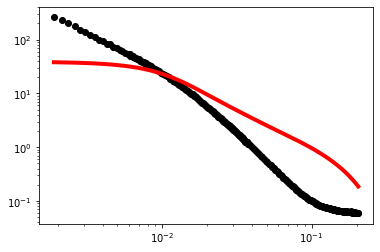

In [136]:
plt.errorbar(sans.x,sans.y,yerr=sans.dy,fmt='o',color='black')
sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='red')

plt.xscale('log')
plt.yscale('log')

In [131]:
key = 'TU11'
kernel = load_model("cylinder")

# loading the data
sans = sans_data[key]
sans.dx = sans.dx-sans.dx # removing smearing from sans segment
#usans = usans_data[key]

# initial parameter values

scale = Parameter(0.05, name='scale').range(0,1)
background = Parameter(0.1, name='background').range(0,1)

length = Parameter(100000,name='length',limits=[0,inf]).range(1000,inf)
length_pd = Parameter(0)

# kuhn_length = Parameter(100,name='kuhn length',limits=[0,inf]).range(0,inf)
# kuhn_length_pd = Parameter(0)

radius = Parameter(200,name='radius',limits=[0,inf]).range(0,1000)
radius_pd = Parameter(0.5)

sld = Parameter(slds[cps[key]])
sld_solvent = Parameter(slds[solvent_names[key]])

# setting up the combined model for fitting
sans_model = Model(
    model=kernel,
    scale=scale,
    background=background,
    length=length,
    length_pd=length_pd,
    #kuhn_length=kuhn_length,
    #kuhn_length_pd=kuhn_length_pd,
    radius=radius,
    radius_pd=radius_pd,
    sld=sld,
    sld_solvent=sld_solvent,
)


sans_experiment=Experiment(data=sans, model=sans_model)
problem=FitProblem(sans_experiment)
result=fit(problem, method='lm',verbose=True)

#problem.plot()

final chisq 467.166(17)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                              background 0.075714(95)    0.0757140(44)  
                                  length 100168(82)      100167.9(38)   
                                  radius 41.773(27)      41.7728(12)    
                                   scale 0.0023316(17)   0.002331628(81)


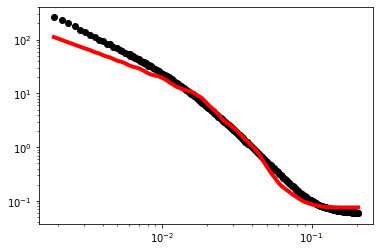

In [132]:
plt.errorbar(sans.x,sans.y,yerr=sans.dy,fmt='o',color='black')
sort_mask = np.argsort(sans.x)
plt.errorbar(sans.x[sort_mask],problem.fitness.theory()[sort_mask],fmt='-',linewidth=4,color='red')

plt.xscale('log')
plt.yscale('log')